# Digit Recognizer using ResNets, Regularization and Data Augmentation in PyTorch

_A.K.A. Training an image classifier from scratch to over 90% accuracy in less than 5 minutes on a single GPU_

In this notebook, we'll use the following techniques to train a state-of-the-art model in less than 5 minutes to achieve over 90% accuracy in  classifying images from the MNIST dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

### Using a GPU for faster training

You can use a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

* _Google Colab_: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
* _Kaggle_: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
* _Binder_: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
* _Linux_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS is not compatible with NVIDIA GPUs


If you do not have access to a GPU or aren't sure what it is, don't worry, you can execute all the code in this tutorial just fine without a GPU.

Let's begin by importing the required libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
Y_train = train_data["label"]

# Drop 'label' column
X_train = train_data.drop(labels = ["label"], axis = 1)

In [5]:
# free some space
del train_data 

Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

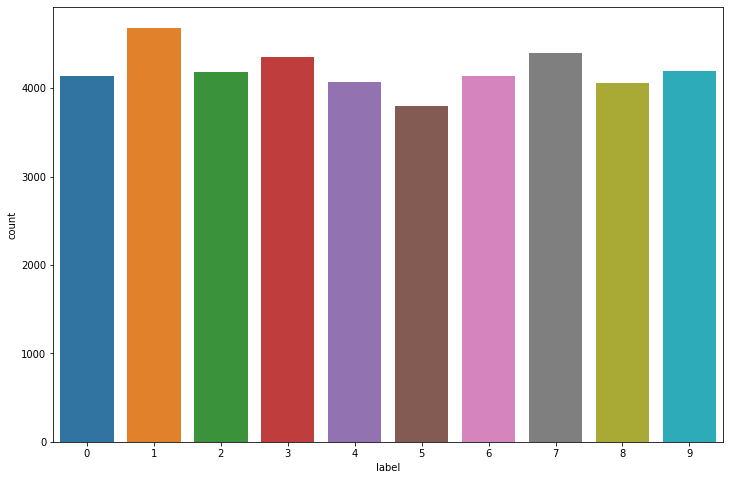

In [6]:
plt.figure(figsize=(12,8));

sns.countplot(Y_train);

In [7]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
# Normalize the data
X_train = X_train / 255.0
test_data = test_data / 255.0

In [10]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , chanal = 1)
X_train = X_train.values.reshape(-1,1,28,28)
test_data = test_data.values.reshape(-1,1,28,28)

In [11]:
X_train

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]

In [12]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train.values)
test_data = torch.from_numpy(test_data).float()

In [13]:
X_train.shape

torch.Size([42000, 1, 28, 28])

In [14]:
test_data.shape

torch.Size([28000, 1, 28, 28])

In [15]:
train_data = TensorDataset(X_train, Y_train)

In [16]:
train_ds, val_ds = random_split(train_data, [38000, 4000])
len(train_ds), len(val_ds)

(38000, 4000)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 400 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [17]:
batch_size = 400

In [18]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in a [previous notebook](https://jovian.ml/kumar-shailesh1597/04-feedforward-nn#C21).

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [20]:
device = get_default_device()
device

device(type='cpu')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

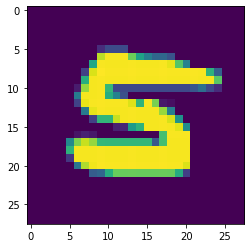

In [23]:
plt.imshow(train_ds[0][0].permute(1,2,0));

In [24]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

## Model with Residual Blocks and Batch Normalization

Here we are using Residual blocks, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

We will use the ResNet9 architecture, as shown below:

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [27]:
model = to_device(ResNet9(1, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to the `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3034839630126953, 'val_acc': 0.10050000995397568}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [32]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00392, train_loss: 0.2379, val_loss: 0.1182, val_acc: 0.9633
Epoch [1], last_lr: 0.00935, train_loss: 0.1046, val_loss: 0.1138, val_acc: 0.9685
Epoch [2], last_lr: 0.00972, train_loss: 0.0711, val_loss: 0.0529, val_acc: 0.9865
Epoch [3], last_lr: 0.00812, train_loss: 0.0470, val_loss: 0.0416, val_acc: 0.9880
Epoch [4], last_lr: 0.00556, train_loss: 0.0233, val_loss: 0.0347, val_acc: 0.9905
Epoch [5], last_lr: 0.00283, train_loss: 0.0109, val_loss: 0.0265, val_acc: 0.9933
Epoch [6], last_lr: 0.00077, train_loss: 0.0053, val_loss: 0.0230, val_acc: 0.9945
Epoch [7], last_lr: 0.00000, train_loss: 0.0022, val_loss: 0.0223, val_acc: 0.9947
Wall time: 1h 27s


In [34]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

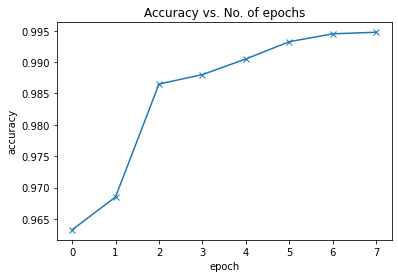

In [35]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

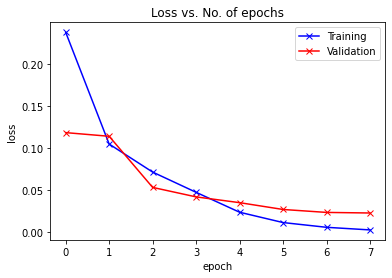

In [37]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [38]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

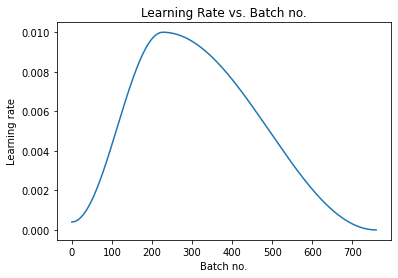

In [39]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images

Let's test out our model with test images from the predefined test dataset of 28000 images.

In [42]:
test_dl = DataLoader(test_data, batch_size*2, num_workers=3, pin_memory=True)

In [46]:
test_data.shape

torch.Size([28000, 1, 28, 28])

In [81]:
def predict_image(test_loader, model):
    
    test_pred = []
    
    # Predict for whole test_data
    for batch in test_loader:
        
        # move batches to device
        xb = to_device(batch, device)
        # Get predictions from model
        yb = model(xb)
        # Pick index with highest probability
        _, preds  = torch.max(yb, dim=1)
        # Retrieve the class label
        for pred in preds:
            test_pred.append(pred)
    return test_pred

In [82]:
test_pred = predict_image(test_dl, model)

In [94]:
# creating a list of column names 
column_name = ['Label'] 

df = pd.DataFrame(data = test_pred, columns = column_name) 

In [95]:
df.insert(0, column='ImageId', value = np.arange(1, 28001, 1))
df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [96]:
torch.save(model.state_dict(), 'digit-recognizer-resnet9.pth')

In [106]:
df.to_csv('submission.csv', index=False)